In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import timeit
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, average_precision_score, matthews_corrcoef
# from util import heat_map, xai_eval_fnc

2023-03-10 17:04:43.217430: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 17:04:43.565962: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-10 17:04:44.899371: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-10 17:04:44.899434: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
import numpy as np
import math
from copy import deepcopy

def xai_eval_fnc(model, relevence, input_x, model_type='lstm', percentile=90,
                 eval_type='prtb', seq_len=10, by='all'):
    """
    Evaluates the quality metrics of time-series importance scores using various evaluation methods.

    Parameters
    ----------
    model : prediction model that is explained 
    relevance : A 3D array of importance scores for each time step of the time-series data
    input_x : input data of the prediction model. If the input data consists of different modalities, the first module should be a 3D time series data
    model_type (optional) : type of model, either 'lstm' or 'lstm_plus'. Use 'lstm' when the time series data is the only modality of the input, otherwise use 'lstm_plus'
    percentile (optional) : percentile of top time steps that are going to be pertubed
    eval_type (optional) : evaluation method, either 'prtb' for the perturbation analysis metric or 'sqnc' for sequence analysis metric
    seq_len (optional) : sequence length for 'sqnc' method
    by (optional) : whether to evaluate each temporal feature separately or all time steps together, either 'time' or 'all'

    Returns : prediction of the modified input time-series data using the input model
    """
    
    input_new = deepcopy(input_x)
    relevence = np.absolute(relevence)
    
    # TO DO: Add other type of models
    if model_type == 'lstm_plus':
        input_ts = input_x[0]
        input_new_ts = input_new[0]
    elif model_type == 'lstm':
        input_ts = input_x
        input_new_ts = input_new
    
    assert len(input_ts.shape)==3 # the time sereis data needs to be 3-dimensional
    num_feature = input_ts.shape[2]
    num_time_step = input_ts.shape[1]
    num_instance = input_ts.shape[0]
        
    if by=='time':
        top_steps = math.ceil((1 - percentile/100) * num_time_step) # finding the number of top steps for each feature
        top_indices = np.argsort(relevence, axis=1)[:, -top_steps:, :] # a 3d array of top time steps for each feature
        for j in range(num_feature): # converting the indices to a flatten version
            top_indices[:, :, j] = top_indices[:, :, j] * num_feature + j
        top_indices = top_indices.flatten()
    elif by=='all':
        top_steps = math.ceil((1 - percentile/100) * num_time_step * num_feature) # finding the number of all top steps
        top_indices = np.argsort(relevence, axis=None)[-top_steps:]
    # print(top_indices)
    
    # Create a masking matrix for top time steps
    top_indices_mask = np.zeros(input_ts.size)
    top_indices_mask[top_indices] = 1
    top_indices_mask = top_indices_mask.reshape(input_ts.shape)
    
    
    # Evaluating different metrics
    for p in range(num_instance):
        for v in range(num_feature):
            for t in range(num_time_step):
                if top_indices_mask[p, t, v]:
                    if eval_type == 'prtb':
                        input_new_ts[p,t,v] = np.max(input_ts[p,:,v]) - input_ts[p,t,v]
                        # input_new_ts[p,t,v] = 0 ### possible edit here
                    elif eval_type == 'sqnc':
                        input_new_ts[p, t:t + seq_len, v] = 0
    
    return model.predict(input_new)


def heat_map(start, stop, x, shap_values, var_name='Feature 1', plot_type='bar', title=None, val_type='wSHAP values'):
    """
    A function that generates a heatmap with the temporal sequence alongside its Shapley values

    Parameters
    ----------
    start (int): the starting point of the temporal sequence
    stop (int): the ending point of the temporal sequence
    x (np.ndarray): the sequence data
    shap_values (np.ndarray): the Shapley values corresponding to the sequence data
    var_name (str): the name of the variable being plotted (default: 'Feature 1')
    plot_type (str): the type of plot to generate ('bar' or 'heat' or 'heat_abs', default: 'bar')
    title (str): the title for the plot (default: None)
    """
    import matplotlib.pyplot as plt
    from matplotlib.colors import LinearSegmentedColormap
    from matplotlib.colors import BoundaryNorm
    from textwrap import wrap
    import numpy as np; np.random.seed(1)
    
    ## ColorMap-------------------------
    # define the colormap
    cmap = plt.get_cmap('PuOr_r')

    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # create the new map
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

    # define the bins and normalize and forcing 0 to be part of the colorbar!
    bounds = np.arange(np.min(shap_values),np.max(shap_values),.5)
    idx=np.searchsorted(bounds,0)
    bounds=np.insert(bounds,idx,0)
    norm = BoundaryNorm(bounds, cmap.N)
    # print(bounds)
    ##------------------------------------
    
    if title is None: title = '\n'.join(wrap('{} values and contribution scores'.format(var_name), width=40))
    
    if plot_type=='heat' or plot_type=='heat_abs':
        plt.rcParams["figure.figsize"] = 9,3
        if plot_type=='heat_abs':
            shap_values = np.absolute(shap_values)
            cmap = 'Reds'
        fig, ax1 = plt.subplots(sharex=True)
        extent = [start, stop, -2, 2]
        im1 = ax1.imshow(shap_values[np.newaxis, :], cmap=cmap, norm=norm, aspect="auto", extent=extent)
        ax1.set_yticks([])
        ax1.set_xlim(extent[0], extent[1])
        ax1.title.set_text(title)
        fig.colorbar(im1, ax=ax1, pad=0.1)
        ax2 = ax1.twinx()
        ax2.plot(np.arange(start, stop), x, color='black')
    elif plot_type=='bar':
        plt.rcParams["figure.figsize"] = 8.5,2.5
        fig, ax1 = plt.subplots(sharex=True)
        mask1 = shap_values < 0
        mask2 = shap_values >= 0
        ax1.bar(np.arange(start, stop)[mask1], shap_values[mask1], color='blue', label='Negative Shapley values')
        ax1.bar(np.arange(start, stop)[mask2], shap_values[mask2], color='red', label='Positive Shapley values')
        ax1.set_title(title)
        ax2 = ax1.twinx()
        ax2.plot(np.arange(start, stop), x, 'k-', label='Observed data')
        # legends
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        # ax2.legend(lines + lines2, labels + labels2, loc=0)
    
    ax1.set_xlabel('Time steps')
    if plot_type=='bar': ax1.set_ylabel(val_type)
    ax2.set_ylabel(var_name + ' data values')
    plt.tight_layout()
    plt.show()

In [3]:
# %load_ext autoreload
# %reload_ext util

In [4]:
##### load data and reformat
data = np.load('train_test_x_y_01.npz')
train_x, test_x, train_y, test_y  = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3'] 
train_y = train_y.reshape(-1,1)
test_y  = test_y.reshape(-1,1)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)



(18390, 48, 26) (4598, 48, 26) (18390, 1) (4598, 1)


In [5]:
#### load model

# model = keras.models.load_model('mimic3_ts_transformer_4march_wattscores_48x26x26.h5_best.hdf5', compile=False)
model = keras.models.load_model('good_models/weights-improvement-cv01.hdf5', compile=False) # better model


## define model loss to be used later
keras_loss = keras.losses.BinaryCrossentropy(from_logits=True)

2023-03-10 17:04:53.005264: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-03-10 17:04:53.005289: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: Legion5
2023-03-10 17:04:53.005294: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: Legion5
2023-03-10 17:04:53.005410: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.85.12
2023-03-10 17:04:53.005424: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.85.12
2023-03-10 17:04:53.005428: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 525.85.12
2023-03-10 17:04:53.005759: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

In [6]:
y_train_pred = model.predict(train_x, verbose=0)
print(roc_auc_score(train_y, y_train_pred))
print(average_precision_score(train_y, y_train_pred))
print(f1_score(train_y, np.round(y_train_pred)))
print(recall_score(train_y, np.round(y_train_pred)))
print(precision_score(train_y, np.round(y_train_pred)))
print(matthews_corrcoef(train_y, np.round(y_train_pred)))
# print('Model Loss: ',"{:.4f}".format(keras_loss(train_y, model.predict(train_x, verbose=0)).numpy()))

0.8986881695730399
0.607958786810349
0.5089883679943603
0.3941048034934498
0.718407960199005
0.4967673500389786


In [7]:
y_test_pred = model.predict(test_x, verbose=0)
print(roc_auc_score(test_y,y_test_pred ))
print(average_precision_score(test_y,y_test_pred ))
print(f1_score(test_y, np.round(y_test_pred)))
print(recall_score(test_y, np.round(y_test_pred)))
print(precision_score(test_y, np.round(y_test_pred)))
print(matthews_corrcoef(test_y, np.round(y_test_pred)))
# print('Model Loss: ',"{:.4f}".format(keras_loss(test_y, model.predict(test_x, verbose=0)).numpy()))

0.7103954391072296
0.2674850062264698
0.2347560975609756
0.16812227074235808
0.3888888888888889
0.2049091107900389


In [8]:
#### for multi_head_attention 
att_layerout_MHA0= keras.Model(inputs=model.input, outputs=model.get_layer('multi_head_attention').output)

In [9]:
att_output_MHA0 = att_layerout_MHA0.predict(test_x, verbose=0)

2023-03-10 17:05:13.672879: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 596783616 exceeds 10% of free system memory.


In [10]:
att_outvals_MHA0, att_scores_MHA0 = att_output_MHA0
# print(att_outvals_MHA0.shape, att_scores_MHA0.shape)
temp_att_scores_dim2 = np.mean(att_scores_MHA0,axis=2) ###the right way
temp_att_scores_dim3 = np.mean(att_scores_MHA0,axis=3) ###
print(att_outvals_MHA0.shape, temp_att_scores_dim2.shape,temp_att_scores_dim3.shape )


(4598, 48, 26) (4598, 48, 26) (4598, 48, 26)


In [11]:
# temp_att_scores_joined = temp_att_scores_dim2+temp_att_scores_dim3

In [12]:
# temp_att_scores_joined.shape

In [13]:
# np.save('MHA_scores.npy',temp_att_scores_dim2)
# np.save('MHA_output.npy', att_outvals_MHA0)

In [14]:
# temp_att_scores_dim2 = np.load('MHA_output.npy') ### all test patients
# att_scores_dim2 = np.load('MHA_scores.npy') ### all test patients

In [15]:
######## visualization of attention scores
feature_map_mimic_26 = ['ANION GAP', 'ALBUMIN', 'BICARBONATE', 'BILIRUBIN','CREATININE', 'CHLORIDE', 'GLUCOSE', 'HEMATOCRIT', 
                     'LACTATE', 'MAGNESIUM', 'PHOSPHATE','PLATELET', 'POTASSIUM', 'PTT','INR', 'PT', 
                     'SODIUM', 'BUN', 'WBC', 'HeartRate', 'SysBP', 'DiasBP', 'MeanBP', 'RespRate', 'SpO2','Temp']

In [16]:
############# load wSHAP results

############# load wSHAP scores obtained from HPC

# ts_phi_1_01_50 = np.load('mhat_ts_phi_1_p01_p50.npy') #p1-p50
# ts_phi_2_01_50 = np.load('mhat_ts_phi_2_p01_p50.npy') #p1-p50
# ts_phi_3_01_50 = np.load('mhat_ts_phi_3_p01_p50.npy') #p1-p50

# ts_phi_1_51_100 = np.load('mhat_ts_phi_1_p51_p100.npy') #p51-p100
# ts_phi_2_51_100 = np.load('mhat_ts_phi_2_p51_p100.npy') #p51-p100
# ts_phi_3_51_100 = np.load('mhat_ts_phi_3_p51_p100.npy') #p51-p100



In [17]:
# ### join both numpy matrix
# ts_phi_1 = np.concatenate((ts_phi_1_01_50,ts_phi_1_51_100))
# ts_phi_2 = np.concatenate((ts_phi_2_01_50,ts_phi_2_51_100))
# ts_phi_3 = np.concatenate((ts_phi_3_01_50,ts_phi_3_51_100))
# ts_phi_1.shape, ts_phi_2.shape, ts_phi_3.shape

In [18]:
########load new SHAP on better model

In [19]:
### scaler function
#xnormalized=(b−a)x−min(x)max(x)−min(x)+a

def ab_scaler(data,a,b):
    sdata = (b-a)*((data - np.min(data))/(np.max(data) - np.min(data))) + a
    return sdata

# ab_scaler(np.asarray([0,0.25, 0.5, 0.75, 1.00]), -1, 1)


In [20]:
# ################## some analysis of values
# att_scores_p100 = temp_att_scores_dim2[:100]
# att_scores_p100.shape, ts_phi_1.shape

In [21]:
######### load new SHAP
ts_phi_1 = np.load('better_model_wshap/mhat_ts_phi_1_p100_wl12.npy') #p1-p100
ts_phi_2 = np.load('better_model_wshap/mhat_ts_phi_2_p100_wl12s06.npy') #p1-p100
ts_phi_3 = np.load('better_model_wshap/mhat_ts_phi_3_d0p01_nw24.npy') #p1-p100


In [22]:
################### visualization wSHAP vs attention
import seaborn as sns
import matplotlib.pyplot as plt



In [23]:
##### scale wSHAP as well
# ts_phi_1 = ab_scaler(ts_phi_1,0,1)
# ts_phi_2 = ab_scaler(ts_phi_2,0,1)

In [24]:
num_test = 0 #till 99 
var = 18        #### feature index
phi_index = 0   #### patient index

In [25]:
# temp_att_scores_dim2 = ab_scaler(temp_att_scores_dim2,-1,1)
# temp_att_scores_dim2 = temp_att_scores_dim2

wshap_feat2 = ts_phi_2[num_test + phi_index, :, var]

In [26]:
np.where(np.any(test_y==1, axis=1))

(array([   2,   12,   28,   36,   50,   68,   77,   80,   82,  116,  119,
         131,  136,  154,  187,  203,  206,  209,  221,  236,  244,  263,
         307,  311,  315,  320,  338,  355,  367,  371,  375,  376,  378,
         381,  390,  392,  409,  453,  455,  456,  504,  514,  525,  545,
         553,  557,  562,  568,  570,  590,  596,  610,  612,  636,  638,
         643,  645,  650,  658,  661,  678,  702,  707,  717,  723,  744,
         745,  753,  754,  756,  757,  759,  772,  778,  788,  790,  791,
         806,  824,  832,  835,  845,  853,  856,  861,  885,  897,  904,
         935,  984,  998, 1002, 1003, 1018, 1047, 1055, 1075, 1078, 1079,
        1081, 1087, 1093, 1094, 1095, 1105, 1119, 1122, 1131, 1144, 1176,
        1200, 1210, 1213, 1221, 1228, 1237, 1252, 1257, 1266, 1270, 1305,
        1307, 1313, 1314, 1329, 1344, 1362, 1371, 1372, 1374, 1381, 1392,
        1393, 1398, 1403, 1412, 1417, 1423, 1443, 1457, 1458, 1477, 1493,
        1502, 1510, 1530, 1551, 1563, 

In [27]:
ts_phi_2[num_test + phi_index, :, :].T.shape

(26, 48)

In [28]:
# phi_index_hm = 1
# ax = sns.heatmap(ab_scaler(test_x[num_test + phi_index_hm, :, :].T,0,1), cmap="BuPu")
# plt.show()

In [29]:

# ax = sns.heatmap(ab_scaler(ts_phi_2[num_test + phi_index_hm, :, :].T,0,1), cmap="BuPu")
# plt.show()

In [30]:
# ax = sns.heatmap(ab_scaler(temp_att_scores_dim2[num_test + phi_index_hm, :, :].T,0,1), cmap="BuPu")
# plt.show()

In [31]:
# ax = sns.heatmap(ab_scaler(temp_att_scores_dim3[num_test + phi_index_hm, :, :].T,0,1), cmap="BuPu")
# plt.show()

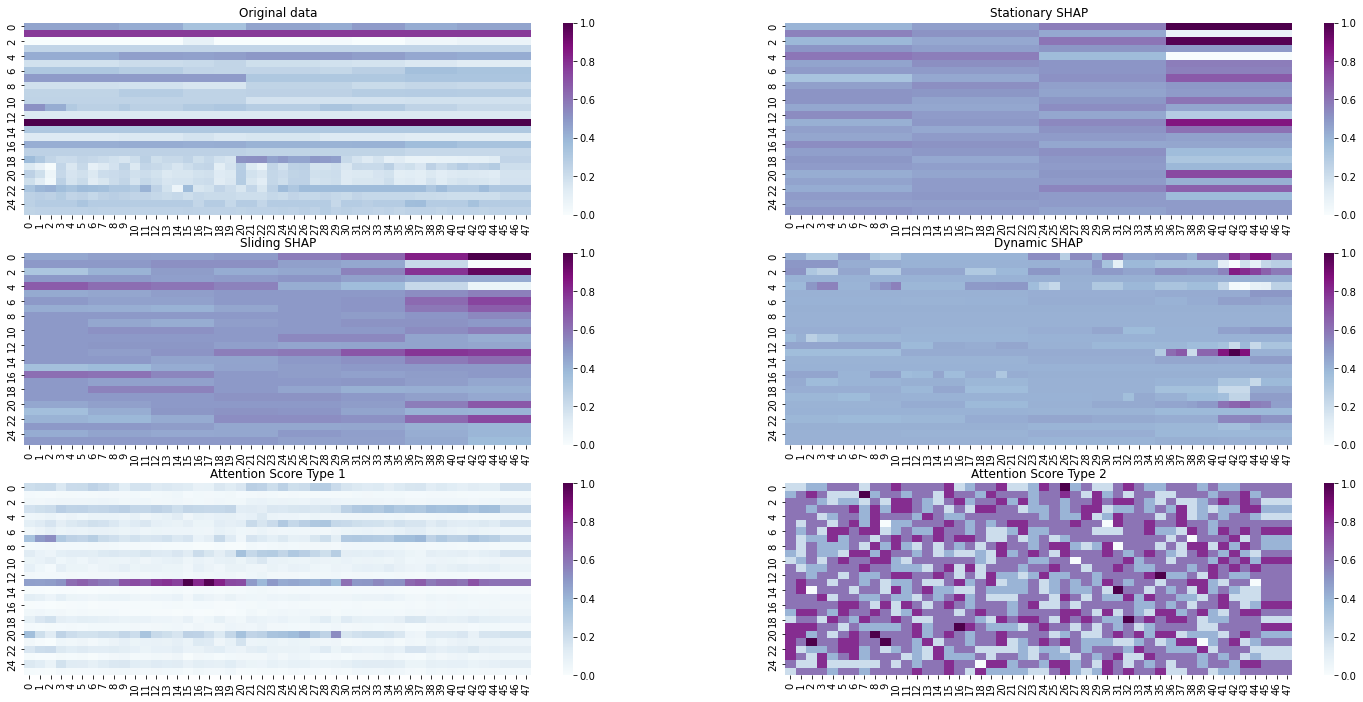

In [32]:
fig, axes = plt.subplots(3, 2, figsize=(25, 12))
phi_index_hm = 2
ax1 = sns.heatmap(ab_scaler(test_x[num_test + phi_index_hm, :, :].T,0,1), cmap="BuPu",ax=axes[0,0],)
axes[0,0].title.set_text('Original data')

sns.heatmap(ab_scaler(ts_phi_1[num_test + phi_index_hm, :, :].T,0,1), cmap="BuPu",ax=axes[0,1],)
axes[0,1].title.set_text('Stationary SHAP')

sns.heatmap(ab_scaler(ts_phi_2[num_test + phi_index_hm, :, :].T,0,1), cmap="BuPu",ax=axes[1,0],)
axes[1,0].title.set_text('Sliding SHAP')

sns.heatmap(ab_scaler(ts_phi_3[num_test + phi_index_hm, :, :].T,0,1), cmap="BuPu",ax=axes[1,1],)
axes[1,1].title.set_text('Dynamic SHAP')

sns.heatmap(ab_scaler(temp_att_scores_dim2[num_test + phi_index_hm, :, :].T,0,1), cmap="BuPu",ax=axes[2,0],)
axes[2,0].title.set_text('Attention Score Type 1')

sns.heatmap(ab_scaler(temp_att_scores_dim3[num_test + phi_index_hm, :, :].T,0,1), cmap="BuPu",ax=axes[2,1],)
axes[2,1].title.set_text('Attention Score Type 2')

# ax1.tick_params(axis='both', which='both', length=0)
# axes[0,0].title.set_text('First Plot')
plt.show()

In [33]:
# ax = sns.heatmap(ab_scaler(temp_att_scores_dim2[num_test + phi_index_hm, :, :].T,0,1)
#                  +ab_scaler(temp_att_scores_dim3[num_test + phi_index_hm, :, :].T,0,1), cmap="BuPu")
# plt.show()

In [36]:
# (np.mean(ab_scaler(ts_phi_3[num_test + phi_index_hm, :, :].T,0,1)), 
# np.mean(ab_scaler(temp_att_scores_dim2[num_test + phi_index_hm, :, :].T,0,1)),
# np.mean(ab_scaler(temp_att_scores_dim3[num_test + phi_index_hm, :, :].T,0,1)),
# # np.mean(ab_scaler(temp_att_scores_joined[num_test + phi_index_hm, :, :].T,0,1)))

In [37]:
# (np.std(ab_scaler(ts_phi_3[num_test + phi_index_hm, :, :].T,0,1)),
# np.std(ab_scaler(temp_att_scores_dim2[num_test + phi_index_hm, :, :].T,0,1)),
# np.std(ab_scaler(temp_att_scores_dim3[num_test + phi_index_hm, :, :].T,0,1)),
#       )

## Heatmap for Attention scores

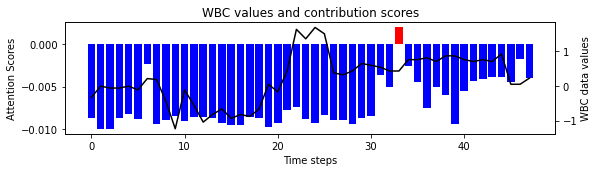

In [38]:

att_feat = temp_att_scores_dim2[num_test + phi_index, :, var]
att_feat = ab_scaler(att_feat,np.min(wshap_feat2),np.max(wshap_feat2))
heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=att_feat, var_name=feature_map_mimic_26[var], plot_type='bar', val_type='Attention Scores')

## Heatmap for Stationary SHAP

In [39]:
# heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=ts_phi_1[num_test + phi_index, :, var], var_name=feature_map_mimic_26[var], plot_type='bar')


# wshap_feat1 = ts_phi_1[num_test + phi_index, :, var]
# wshap_feat1 = ab_scaler(wshap_feat1, np.min(att_feat), np.max(att_feat))
# wshap_feat1 = ab_scaler(wshap_feat1,-1,1)
# heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=wshap_feat1, var_name=feature_map_mimic_26[var], plot_type='bar')

## Heatmap for Sliding SHAP

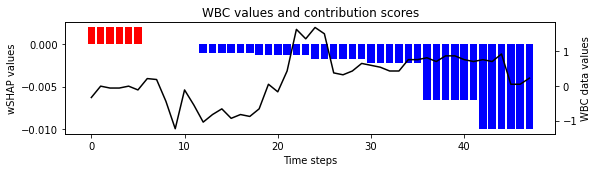

In [40]:
try:
    wshap_feat2 = ts_phi_2[num_test + phi_index, :, var]
    heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=wshap_feat2, var_name=feature_map_mimic_26[var], plot_type='bar')
except:
    # heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=np.random(ts_phi_2.shape)[num_test + phi_index, :, var], var_name=feature_map_mimic_26[var], plot_type='bar')
    pass

# wshap_feat2 = ts_phi_2[num_test + phi_index, :, var]
# wshap_feat2 = ab_scaler(wshap_feat2, np.min(att_feat), np.max(att_feat))
# wshap_feat2 = ab_scaler(wshap_feat2,-1,1)
# try:
#     heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=wshap_feat2, var_name=feature_map_mimic_26[var], plot_type='bar')
# except:
#     # heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=np.random(ts_phi_2.shape)[num_test + phi_index, :, var], var_name=feature_map_mimic_26[var], plot_type='bar')
#     pass


## Heatmap for Dynamic SHAP

In [41]:
heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=ts_phi_3[num_test + phi_index, :, var], var_name=feature_map_mimic_26[var], plot_type='bar')

ValueError: You must provide at least 2 boundaries (1 region) but you passed in array([0.])

## All together

In [85]:
# ### good pairs of var and phi_index: 6,0 - 19,0 - 22,0 -24,0
# # num_test = 0 #50 in next turn
# # var = 0        #### feature index
# # phi_index = 0 

# heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=temp_att_scores_dim2[num_test + phi_index, :, var], var_name=feature_map_mimic_26[var], plot_type='bar', val_type='Attention Scores', title='MH Attention Scores')
# heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=ts_phi_1[num_test + phi_index, :, var], var_name=feature_map_mimic_26[var], plot_type='bar', title='Stationary SHAP')
# try:
#     heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=ts_phi_2[num_test + phi_index, :, var], var_name=feature_map_mimic_26[var], plot_type='bar', title='Sliding SHAP')
# except:
#     # heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=np.random(ts_phi_2.shape)[num_test + phi_index, :, var], var_name=feature_map_mimic_26[var], plot_type='bar')
#     pass
# try:
#     heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=ts_phi_3[num_test + phi_index, :, var], var_name=feature_map_mimic_26[var], plot_type='bar',title='Dynamic SHAP')
# except:
#     pass

# heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=temp_att_scores_dim2[num_test + phi_index, :, var], var_name=feature_map_mimic_26[var], plot_type='heat', val_type='Attention Scores', title='MH Attention Scores')
# try:
#     heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=ts_phi_1[num_test + phi_index, :, var], var_name=feature_map_mimic_26[var], plot_type='heat', title='Stationary SHAP')
# except:
#     pass
# try:
#     heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=ts_phi_2[num_test + phi_index, :, var], var_name=feature_map_mimic_26[var], plot_type='heat', title='Sliding SHAP')
# except:
#     # heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=np.random(ts_phi_2.shape)[num_test + phi_index, :, var], var_name=feature_map_mimic_26[var], plot_type='bar')
#     pass
# try:
#     heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=ts_phi_3[num_test + phi_index, :, var], var_name=feature_map_mimic_26[var], plot_type='heat',title='Dynamic SHAP')
# except:
#     pass
    
    
    
    
    

In [23]:
########## perturbation and seq based analysis; change in loss and metrics

In [42]:
######## original model output for 100 test patients:
######### model prediction
y_pred_orig = model.predict(test_x[:100,:,:])
# y_pred_orig


#### get original values of test set predictions
test_y_n = test_y[:100]

4/4 [==============================] - 0s 11ms/step


In [43]:
# test_y_n

In [44]:
#### metrics on original test data

print('Original Model Predictions: ')
print('AUC ROC   : ',"{:.4f}".format(roc_auc_score(test_y_n, y_pred_orig)))
print('AUC PR    : ',"{:.4f}".format(average_precision_score(test_y_n, y_pred_orig)))
print('F1 Score  : ',"{:.4f}".format(f1_score(test_y_n, np.where(y_pred_orig > 0.5, 1, 0))))
print('Recall    : ',"{:.4f}".format(recall_score(test_y_n,np.where(y_pred_orig > 0.5, 1, 0))))
print('Precision : ',"{:.4f}".format(precision_score(test_y_n,np.where(y_pred_orig > 0.5, 1, 0))))
print('MCC       : ',"{:.4f}".format(matthews_corrcoef(test_y_n,np.where(y_pred_orig > 0.5, 1, 0))))
print('Model Loss: ',"{:.4f}".format(keras_loss(test_y_n, y_pred_orig).numpy()))

Original Model Predictions: 
AUC ROC   :  0.6581
AUC PR    :  0.1396
F1 Score  :  0.0000
Recall    :  0.0000
Precision :  0.0000
MCC       :  -0.0642
Model Loss:  0.7527


In [45]:
##### perturbations based on wSHAP
#xai_eval_fnc(model, relevence, input_x)
# xai_wSHAP_prtb_tsphi1 = xai_eval_fnc(model, ts_phi_1, test_x[:100], eval_type='prtb',percentile=90) #stationary
xai_wSHAP_prtb_tsphi2 = xai_eval_fnc(model, ts_phi_2, test_x[:100], eval_type='prtb',
                                     by='all',
                                     percentile=90) #sliding
xai_wSHAP_prtb_tsphi3 = xai_eval_fnc(model, ts_phi_3, test_x[:100], eval_type='prtb',
                                     by='all',
                                     percentile=90) #dynamic

#### sequence analysis on wSHAP
seq_len_val  = 12
# xai_wSHAP_sqnc_tsphi1 = xai_eval_fnc(model, ts_phi_1, test_x[:100], eval_type='sqnc',seq_len=seq_len_val,percentile=90) #stationary
xai_wSHAP_sqnc_tsphi2 = xai_eval_fnc(model, ts_phi_2, test_x[:100], eval_type='sqnc',seq_len=seq_len_val,
                                     by='all',
                                     percentile=90) #sliding
xai_wSHAP_sqnc_tsphi3 = xai_eval_fnc(model, ts_phi_3, test_x[:100], eval_type='sqnc',seq_len=seq_len_val,
                                     by='all',
                                     percentile=90) #dynamic

4/4 [==============================] - 0s 10ms/step


In [46]:
import warnings
warnings.filterwarnings('ignore')
# ###### stationary
# print('Stationary wSHAP Perturbation Analysis Predictions: ')
# print('AUC ROC   : ',"{:.4f}".format(roc_auc_score(test_y_n, xai_wSHAP_prtb_tsphi1)))
# print('AUC PR    : ',"{:.4f}".format(average_precision_score(test_y_n, xai_wSHAP_prtb_tsphi1)))
# print('F1 Score  : ',"{:.4f}".format(f1_score(test_y_n, np.where(xai_wSHAP_prtb_tsphi1 > 0.5, 1, 0))))
# print('Recall    : ',"{:.4f}".format(recall_score(test_y_n,np.where(xai_wSHAP_prtb_tsphi1 > 0.5, 1, 0))))
# print('Precision : ',"{:.4f}".format(precision_score(test_y_n,np.where(xai_wSHAP_prtb_tsphi1 > 0.5, 1, 0))))
# print('MCC       : ',"{:.4f}".format(matthews_corrcoef(test_y_n,np.where(xai_wSHAP_prtb_tsphi1 > 0.5, 1, 0))))
# print('Model Loss: ',"{:.4f}".format(keras_loss(test_y_n, xai_wSHAP_prtb_tsphi1).numpy()))
# print('')
###### sliding
print('Sliding wSHAP Perturbation Analysis Predictions: ')
print('AUC ROC   : ',"{:.4f}".format(roc_auc_score(test_y_n, xai_wSHAP_prtb_tsphi2)))
print('AUC PR    : ',"{:.4f}".format(average_precision_score(test_y_n, xai_wSHAP_prtb_tsphi2)))
print('F1 Score  : ',"{:.4f}".format(f1_score(test_y_n, np.where(xai_wSHAP_prtb_tsphi2 > 0.5, 1, 0))))
print('Recall    : ',"{:.4f}".format(recall_score(test_y_n,np.where(xai_wSHAP_prtb_tsphi2 > 0.5, 1, 0))))
print('Precision : ',"{:.4f}".format(precision_score(test_y_n,np.where(xai_wSHAP_prtb_tsphi2 > 0.5, 1, 0))))
print('MCC       : ',"{:.4f}".format(matthews_corrcoef(test_y_n,np.where(xai_wSHAP_prtb_tsphi2 > 0.5, 1, 0))))
print('Model Loss: ',"{:.4f}".format(keras_loss(test_y_n, xai_wSHAP_prtb_tsphi2).numpy()))
print('')
############# dynamic
print('Dynamic wSHAP Perturbation Analysis Predictions: ')
print('AUC ROC   : ',"{:.4f}".format(roc_auc_score(test_y_n, xai_wSHAP_prtb_tsphi3)))
print('AUC PR    : ',"{:.4f}".format(average_precision_score(test_y_n, xai_wSHAP_prtb_tsphi3)))
print('F1 Score  : ',"{:.4f}".format(f1_score(test_y_n, np.where(xai_wSHAP_prtb_tsphi3 > 0.5, 1, 0))))
print('Recall    : ',"{:.4f}".format(recall_score(test_y_n,np.where(xai_wSHAP_prtb_tsphi3 > 0.5, 1, 0))))
print('Precision : ',"{:.4f}".format(precision_score(test_y_n,np.where(xai_wSHAP_prtb_tsphi3 > 0.5, 1, 0))))
print('MCC       : ',"{:.4f}".format(matthews_corrcoef(test_y_n,np.where(xai_wSHAP_prtb_tsphi3 > 0.5, 1, 0))))
print('Model Loss: ',"{:.4f}".format(keras_loss(test_y_n, xai_wSHAP_prtb_tsphi3).numpy()))
print('')
# ###### stationary
# print(f'Stationary wSHAP Sequence {seq_len_val} Analysis Predictions: ')
# print('AUC ROC   : ',"{:.4f}".format(roc_auc_score(test_y_n, xai_wSHAP_sqnc_tsphi1)))
# print('AUC PR    : ',"{:.4f}".format(average_precision_score(test_y_n, xai_wSHAP_sqnc_tsphi1)))
# print('F1 Score  : ',"{:.4f}".format(f1_score(test_y_n, np.where(xai_wSHAP_sqnc_tsphi1 > 0.5, 1, 0))))
# print('Recall    : ',"{:.4f}".format(recall_score(test_y_n,np.where(xai_wSHAP_sqnc_tsphi1 > 0.5, 1, 0))))
# print('Precision : ',"{:.4f}".format(precision_score(test_y_n,np.where(xai_wSHAP_sqnc_tsphi1 > 0.5, 1, 0))))
# print('MCC       : ',"{:.4f}".format(matthews_corrcoef(test_y_n,np.where(xai_wSHAP_sqnc_tsphi1 > 0.5, 1, 0))))
# print('Model Loss: ',"{:.4f}".format(keras_loss(test_y_n, xai_wSHAP_sqnc_tsphi1).numpy()))
# print('')
###### sliding
print(f'Sliding wSHAP Sequence {seq_len_val} Analysis Predictions: ')
print('AUC ROC   : ',"{:.4f}".format(roc_auc_score(test_y_n, xai_wSHAP_sqnc_tsphi2)))
print('AUC PR    : ',"{:.4f}".format(average_precision_score(test_y_n, xai_wSHAP_sqnc_tsphi2)))
print('F1 Score  : ',"{:.4f}".format(f1_score(test_y_n, np.where(xai_wSHAP_sqnc_tsphi2 > 0.5, 1, 0))))
print('Recall    : ',"{:.4f}".format(recall_score(test_y_n,np.where(xai_wSHAP_sqnc_tsphi2 > 0.5, 1, 0))))
print('Precision : ',"{:.4f}".format(precision_score(test_y_n,np.where(xai_wSHAP_sqnc_tsphi2 > 0.5, 1, 0))))
print('MCC       : ',"{:.4f}".format(matthews_corrcoef(test_y_n,np.where(xai_wSHAP_sqnc_tsphi2 > 0.5, 1, 0))))
print('Model Loss: ',"{:.4f}".format(keras_loss(test_y_n, xai_wSHAP_sqnc_tsphi2).numpy()))
print('')
###### dynamic
print(f'Dynamic wSHAP Sequence {seq_len_val} Analysis Predictions: ')
print('AUC ROC   : ',"{:.4f}".format(roc_auc_score(test_y_n, xai_wSHAP_sqnc_tsphi3)))
print('AUC PR    : ',"{:.4f}".format(average_precision_score(test_y_n, xai_wSHAP_sqnc_tsphi3)))
print('F1 Score  : ',"{:.4f}".format(f1_score(test_y_n, np.where(xai_wSHAP_sqnc_tsphi3 > 0.5, 1, 0))))
print('Recall    : ',"{:.4f}".format(recall_score(test_y_n,np.where(xai_wSHAP_sqnc_tsphi3 > 0.5, 1, 0))))
print('Precision : ',"{:.4f}".format(precision_score(test_y_n,np.where(xai_wSHAP_sqnc_tsphi3 > 0.5, 1, 0))))
print('MCC       : ',"{:.4f}".format(matthews_corrcoef(test_y_n,np.where(xai_wSHAP_sqnc_tsphi3 > 0.5, 1, 0))))
print('Model Loss: ',"{:.4f}".format(keras_loss(test_y_n, xai_wSHAP_sqnc_tsphi3).numpy()))
print('')

Sliding wSHAP Perturbation Analysis Predictions: 
AUC ROC   :  0.6264
AUC PR    :  0.1291
F1 Score  :  0.0000
Recall    :  0.0000
Precision :  0.0000
MCC       :  -0.0449
Model Loss:  0.7438

Dynamic wSHAP Perturbation Analysis Predictions: 
AUC ROC   :  0.6557
AUC PR    :  0.1520
F1 Score  :  0.0000
Recall    :  0.0000
Precision :  0.0000
MCC       :  0.0000
Model Loss:  0.7371

Sliding wSHAP Sequence 12 Analysis Predictions: 
AUC ROC   :  0.5861
AUC PR    :  0.1212
F1 Score  :  0.0000
Recall    :  0.0000
Precision :  0.0000
MCC       :  -0.0449
Model Loss:  0.7468

Dynamic wSHAP Sequence 12 Analysis Predictions: 
AUC ROC   :  0.5958
AUC PR    :  0.1367
F1 Score  :  0.0000
Recall    :  0.0000
Precision :  0.0000
MCC       :  0.0000
Model Loss:  0.7313



In [47]:
########## Attention scores based metrics
##### perturbations based on attention


sc_att_scores = temp_att_scores_dim2 + temp_att_scores_dim3
# sc_att_scores = ab_scaler(sc_att_scores, np.min(ts_phi_2), np.max(ts_phi_2))

xai_MHA_prtb_tsphi = xai_eval_fnc(model, sc_att_scores[:100], test_x[:100], eval_type='prtb',
                                  by='all',
                                  percentile=90
                                 ) #MH attention
# xai_MHA_prtb_tsphi = xai_eval_fnc(model, temp_att_scores_dim2, test_x, eval_type='prtb') #MH attention


##### sequence based on attention
seq_len_val  = 12
xai_MHA_sqnc_tsphi = xai_eval_fnc(model, sc_att_scores[:100], test_x[:100], eval_type='sqnc',seq_len=seq_len_val,
                                  by='all',
                                  percentile=90
                                 ) #MH attention

# xai_MHA_sqnc_tsphi = xai_eval_fnc(model, temp_att_scores_dim2, test_x, eval_type='sqnc',seq_len=seq_le/n_val) #MH attention


test_y_n = test_y[:100]

4/4 [==============================] - 0s 10ms/step


In [48]:
###### Multihead attention - prtb first 100
print('Multihead Attention Perturbation Analysis Predictions: ')
print('AUC ROC   : ',"{:.4f}".format(roc_auc_score(test_y_n, xai_MHA_prtb_tsphi)))
print('AUC PR    : ',"{:.4f}".format(average_precision_score(test_y_n, xai_MHA_prtb_tsphi)))
print('F1 Score  : ',"{:.4f}".format(f1_score(test_y_n, np.where(xai_MHA_prtb_tsphi > 0.5, 1, 0))))
print('Recall    : ',"{:.4f}".format(recall_score(test_y_n,np.where(xai_MHA_prtb_tsphi > 0.5, 1, 0))))
print('Precision : ',"{:.4f}".format(precision_score(test_y_n,np.where(xai_MHA_prtb_tsphi  > 0.5, 1, 0))))
print('MCC       : ',"{:.4f}".format(matthews_corrcoef(test_y_n,np.where(xai_MHA_prtb_tsphi > 0.5, 1, 0))))
print('Model Loss: ',"{:.4f}".format(keras_loss(test_y_n, xai_MHA_prtb_tsphi ).numpy()))
print('')

###### Multihead attention - sqnc first 100
print(f'Multihead Attention Sequence {seq_len_val} Analysis Predictions: ')
print('AUC ROC   : ',"{:.4f}".format(roc_auc_score(test_y_n, xai_MHA_sqnc_tsphi)))
print('AUC PR    : ',"{:.4f}".format(average_precision_score(test_y_n, xai_MHA_sqnc_tsphi)))
print('F1 Score  : ',"{:.4f}".format(f1_score(test_y_n, np.where(xai_MHA_sqnc_tsphi > 0.5, 1, 0))))
print('Recall    : ',"{:.4f}".format(recall_score(test_y_n,np.where(xai_MHA_sqnc_tsphi > 0.5, 1, 0))))
print('Precision : ',"{:.4f}".format(precision_score(test_y_n,np.where(xai_MHA_sqnc_tsphi  > 0.5, 1, 0))))
print('MCC       : ',"{:.4f}".format(matthews_corrcoef(test_y_n,np.where(xai_MHA_sqnc_tsphi > 0.5, 1, 0))))
print('Model Loss: ',"{:.4f}".format(keras_loss(test_y_n, xai_MHA_sqnc_tsphi ).numpy()))
print('')

Multihead Attention Perturbation Analysis Predictions: 
AUC ROC   :  0.6581
AUC PR    :  0.1396
F1 Score  :  0.0000
Recall    :  0.0000
Precision :  0.0000
MCC       :  -0.0642
Model Loss:  0.7527

Multihead Attention Sequence 12 Analysis Predictions: 
AUC ROC   :  0.6581
AUC PR    :  0.1396
F1 Score  :  0.0000
Recall    :  0.0000
Precision :  0.0000
MCC       :  -0.0642
Model Loss:  0.7527



In [49]:
# ###### Multihead attention - first 100 test
# print('Multihead Attention Perturbation Analysis Predictions: ')
# print('AUC ROC   : ',"{:.4f}".format(roc_auc_score(test_y_n, xai_MHA_prtb_tsphi)))
# print('AUC PR    : ',"{:.4f}".format(average_precision_score(test_y_n, xai_MHA_prtb_tsphi)))
# print('F1 Score  : ',"{:.4f}".format(f1_score(test_y_n, np.where(xai_MHA_prtb_tsphi > 0.5, 1, 0))))
# print('Recall    : ',"{:.4f}".format(recall_score(test_y_n,np.where(xai_MHA_prtb_tsphi > 0.5, 1, 0))))
# print('Precision : ',"{:.4f}".format(precision_score(test_y_n,np.where(xai_MHA_prtb_tsphi  > 0.5, 1, 0))))
# print('MCC       : ',"{:.4f}".format(matthews_corrcoef(test_y_n,np.where(xai_MHA_prtb_tsphi > 0.5, 1, 0))))
# print('Model Loss: ',"{:.4f}".format(keras_loss(test_y_n, xai_MHA_prtb_tsphi ).numpy()))
# print('')

# ###### Multihead attention - sqnc ALL test
# print('Multihead Attention Perturbation Analysis Predictions: ')
# print('AUC ROC   : ',"{:.4f}".format(roc_auc_score(test_y, xai_MHA_prtb_tsphi)))
# print('AUC PR    : ',"{:.4f}".format(average_precision_score(test_y, xai_MHA_prtb_tsphi)))
# print('F1 Score  : ',"{:.4f}".format(f1_score(test_y, np.where(xai_MHA_prtb_tsphi > 0.5, 1, 0))))
# print('Recall    : ',"{:.4f}".format(recall_score(test_y,np.where(xai_MHA_prtb_tsphi > 0.5, 1, 0))))
# print('Precision : ',"{:.4f}".format(precision_score(test_y,np.where(xai_MHA_prtb_tsphi  > 0.5, 1, 0))))
# print('MCC       : ',"{:.4f}".format(matthews_corrcoef(test_y,np.where(xai_MHA_prtb_tsphi > 0.5, 1, 0))))
# print('Model Loss: ',"{:.4f}".format(keras_loss(test_y, xai_MHA_prtb_tsphi ).numpy()))
# print('')

In [50]:
# ###### Multihead attention - sqnc first 100 test
# print(f'Multihead Attention Sequence {seq_len_val} Analysis Predictions: ')
# print('AUC ROC   : ',"{:.4f}".format(roc_auc_score(test_y_n, xai_MHA_sqnc_tsphi)))
# print('AUC PR    : ',"{:.4f}".format(average_precision_score(test_y_n, xai_MHA_sqnc_tsphi)))
# print('F1 Score  : ',"{:.4f}".format(f1_score(test_y_n, np.where(xai_MHA_sqnc_tsphi > 0.5, 1, 0))))
# print('Recall    : ',"{:.4f}".format(recall_score(test_y_n,np.where(xai_MHA_sqnc_tsphi > 0.5, 1, 0))))
# print('Precision : ',"{:.4f}".format(precision_score(test_y_n,np.where(xai_MHA_sqnc_tsphi  > 0.5, 1, 0))))
# print('MCC       : ',"{:.4f}".format(matthews_corrcoef(test_y_n,np.where(xai_MHA_sqnc_tsphi > 0.5, 1, 0))))
# print('Model Loss: ',"{:.4f}".format(keras_loss(test_y_n, xai_MHA_sqnc_tsphi ).numpy()))
# print('')

# ###### Multihead attention - sqnc ALL test
# print(f'Multihead Attention Sequence {seq_len_val} Analysis Predictions: ')
# print('AUC ROC   : ',"{:.4f}".format(roc_auc_score(test_y, xai_MHA_sqnc_tsphi)))
# print('AUC PR    : ',"{:.4f}".format(average_precision_score(test_y, xai_MHA_sqnc_tsphi)))
# print('F1 Score  : ',"{:.4f}".format(f1_score(test_y, np.where(xai_MHA_sqnc_tsphi > 0.5, 1, 0))))
# print('Recall    : ',"{:.4f}".format(recall_score(test_y,np.where(xai_MHA_sqnc_tsphi > 0.5, 1, 0))))
# print('Precision : ',"{:.4f}".format(precision_score(test_y,np.where(xai_MHA_sqnc_tsphi  > 0.5, 1, 0))))
# print('MCC       : ',"{:.4f}".format(matthews_corrcoef(test_y,np.where(xai_MHA_sqnc_tsphi > 0.5, 1, 0))))
# print('Model Loss: ',"{:.4f}".format(keras_loss(test_y, xai_MHA_sqnc_tsphi ).numpy()))
# print('')

In [51]:
###### Multihead attention - prtb first 100
print('Multihead Attention Perturbation Analysis Predictions: ')
print('AUC ROC   : ',"{:.4f}".format(roc_auc_score(test_y_n, xai_MHA_prtb_tsphi)))
print('AUC PR    : ',"{:.4f}".format(average_precision_score(test_y_n, xai_MHA_prtb_tsphi)))
print('F1 Score  : ',"{:.4f}".format(f1_score(test_y_n, np.where(xai_MHA_prtb_tsphi > 0.5, 1, 0))))
print('Recall    : ',"{:.4f}".format(recall_score(test_y_n,np.where(xai_MHA_prtb_tsphi > 0.5, 1, 0))))
print('Precision : ',"{:.4f}".format(precision_score(test_y_n,np.where(xai_MHA_prtb_tsphi  > 0.5, 1, 0))))
print('MCC       : ',"{:.4f}".format(matthews_corrcoef(test_y_n,np.where(xai_MHA_prtb_tsphi > 0.5, 1, 0))))
print('Model Loss: ',"{:.4f}".format(keras_loss(test_y_n, xai_MHA_prtb_tsphi ).numpy()))
print('')

###### Multihead attention - sqnc first 100
print(f'Multihead Attention Sequence {seq_len_val} Analysis Predictions: ')
print('AUC ROC   : ',"{:.4f}".format(roc_auc_score(test_y_n, xai_MHA_sqnc_tsphi)))
print('AUC PR    : ',"{:.4f}".format(average_precision_score(test_y_n, xai_MHA_sqnc_tsphi)))
print('F1 Score  : ',"{:.4f}".format(f1_score(test_y_n, np.where(xai_MHA_sqnc_tsphi > 0.5, 1, 0))))
print('Recall    : ',"{:.4f}".format(recall_score(test_y_n,np.where(xai_MHA_sqnc_tsphi > 0.5, 1, 0))))
print('Precision : ',"{:.4f}".format(precision_score(test_y_n,np.where(xai_MHA_sqnc_tsphi  > 0.5, 1, 0))))
print('MCC       : ',"{:.4f}".format(matthews_corrcoef(test_y_n,np.where(xai_MHA_sqnc_tsphi > 0.5, 1, 0))))
print('Model Loss: ',"{:.4f}".format(keras_loss(test_y_n, xai_MHA_sqnc_tsphi ).numpy()))
print('')

Multihead Attention Perturbation Analysis Predictions: 
AUC ROC   :  0.6581
AUC PR    :  0.1396
F1 Score  :  0.0000
Recall    :  0.0000
Precision :  0.0000
MCC       :  -0.0642
Model Loss:  0.7527

Multihead Attention Sequence 12 Analysis Predictions: 
AUC ROC   :  0.6581
AUC PR    :  0.1396
F1 Score  :  0.0000
Recall    :  0.0000
Precision :  0.0000
MCC       :  -0.0642
Model Loss:  0.7527



In [52]:
# ############## compare perturbation with sqnc
# print('Multihead Attention Perturbation Analysis Predictions: ')
# print('F1 Score  : ',"{:.4f}".format(f1_score(np.where(xai_MHA_prtb_tsphi > 0.5, 1, 0), np.where(xai_MHA_sqnc_tsphi > 0.5, 1, 0))))
# print('Recall    : ',"{:.4f}".format(recall_score(np.where(xai_MHA_prtb_tsphi > 0.5, 1, 0), np.where(xai_MHA_sqnc_tsphi > 0.5, 1, 0))))
# print('Precision : ',"{:.4f}".format(precision_score(np.where(xai_MHA_prtb_tsphi > 0.5, 1, 0), np.where(xai_MHA_sqnc_tsphi > 0.5, 1, 0))))
# print('MCC       : ',"{:.4f}".format(matthews_corrcoef(np.where(xai_MHA_prtb_tsphi > 0.5, 1, 0), np.where(xai_MHA_sqnc_tsphi > 0.5, 1, 0))))
# print('Model Loss: ',"{:.4f}".format(keras_loss(xai_MHA_prtb_tsphi, xai_MHA_sqnc_tsphi ).numpy()))

In [53]:
# ######## check difference
# ######## original model output for 100 test patients:
# ######### model prediction
# numpat = 2000
# # att_output_MHA0 = att_layerout_MHA0.predict(test_x, verbose=0)
# att_output_MHA0 = att_layerout_MHA0.predict(train_x[:numpat,:,:], verbose=0)
# att_outvals_MHA0, att_scores_MHA0 = att_output_MHA0
# # print(att_outvals_MHA0.shape, att_scores_MHA0.shape)
# temp_att_scores_dim2 = np.mean(att_scores_MHA0,axis=2) ###the right way
# # temp_att_scores_dim3 = np.mean(att_scores_MHA0,axis=3) ###
# print(att_outvals_MHA0.shape, temp_att_scores_dim2.shape)

# # temp_att_scores_dim2 = ab_scaler(temp_att_scores_dim2,0,1)
# # temp_att_scores_dim2 = temp_att_scores_dim3


# y_pred_orig = model.predict(train_x[:numpat,:,:])
# # y_pred_orig


# #### get original values of test set predictions
# train_y_n = train_y[:numpat]




# ########## Attention scores based metrics
# ##### perturbations based on attention
# xai_MHA_prtb_tsphi = xai_eval_fnc(model, temp_att_scores_dim2[:numpat], train_x[:numpat], eval_type='prtb',
#                                   percentile=95, 
#                                   # by='time'
#                                  ) #MH attention
# # xai_MHA_prtb_tsphi = xai_eval_fnc(model, temp_att_scores_dim2, test_x, eval_type='prtb') #MH attention


# ##### sequence based on attention
# seq_len_val  = 12
# xai_MHA_sqnc_tsphi = xai_eval_fnc(model, temp_att_scores_dim2[:numpat], train_x[:numpat], eval_type='sqnc',seq_len=seq_len_val,
#                                   percentile=95,
#                                   # by='time'
#                                  ) #MH attention



# #### metrics on original train data

# print('Original Model Predictions: ')
# print('AUC ROC   : ',"{:.4f}".format(roc_auc_score(train_y_n, y_pred_orig)))
# print('AUC PR    : ',"{:.4f}".format(average_precision_score(train_y_n, y_pred_orig)))
# print('F1 Score  : ',"{:.4f}".format(f1_score(train_y_n, np.where(y_pred_orig > 0.5, 1, 0))))
# print('Recall    : ',"{:.4f}".format(recall_score(train_y_n,np.where(y_pred_orig > 0.5, 1, 0))))
# print('Precision : ',"{:.4f}".format(precision_score(train_y_n,np.where(y_pred_orig > 0.5, 1, 0))))
# print('MCC       : ',"{:.4f}".format(matthews_corrcoef(train_y_n,np.where(y_pred_orig > 0.5, 1, 0))))
# print('Model Loss: ',"{:.4f}".format(keras_loss(train_y_n, y_pred_orig).numpy()))
# print('')


# ###### Multihead attention - prtb first 100
# print('Multihead Attention Perturbation Analysis Predictions: ')
# print('AUC ROC   : ',"{:.4f}".format(roc_auc_score(train_y_n, xai_MHA_prtb_tsphi)))
# print('AUC PR    : ',"{:.4f}".format(average_precision_score(train_y_n, xai_MHA_prtb_tsphi)))
# print('F1 Score  : ',"{:.4f}".format(f1_score(train_y_n, np.where(xai_MHA_prtb_tsphi > 0.5, 1, 0))))
# print('Recall    : ',"{:.4f}".format(recall_score(train_y_n,np.where(xai_MHA_prtb_tsphi > 0.5, 1, 0))))
# print('Precision : ',"{:.4f}".format(precision_score(train_y_n,np.where(xai_MHA_prtb_tsphi  > 0.5, 1, 0))))
# print('MCC       : ',"{:.4f}".format(matthews_corrcoef(train_y_n,np.where(xai_MHA_prtb_tsphi > 0.5, 1, 0))))
# print('Model Loss: ',"{:.4f}".format(keras_loss(train_y_n, xai_MHA_prtb_tsphi ).numpy()))
# print('')

# ###### Multihead attention - sqnc first 100
# print(f'Multihead Attention Sequence {seq_len_val} Analysis Predictions: ')
# print('AUC ROC   : ',"{:.4f}".format(roc_auc_score(train_y_n, xai_MHA_sqnc_tsphi)))
# print('AUC PR    : ',"{:.4f}".format(average_precision_score(train_y_n, xai_MHA_sqnc_tsphi)))
# print('F1 Score  : ',"{:.4f}".format(f1_score(train_y_n, np.where(xai_MHA_sqnc_tsphi > 0.5, 1, 0))))
# print('Recall    : ',"{:.4f}".format(recall_score(train_y_n,np.where(xai_MHA_sqnc_tsphi > 0.5, 1, 0))))
# print('Precision : ',"{:.4f}".format(precision_score(train_y_n,np.where(xai_MHA_sqnc_tsphi  > 0.5, 1, 0))))
# print('MCC       : ',"{:.4f}".format(matthews_corrcoef(train_y_n,np.where(xai_MHA_sqnc_tsphi > 0.5, 1, 0))))
# print('Model Loss: ',"{:.4f}".format(keras_loss(train_y_n, xai_MHA_sqnc_tsphi ).numpy()))
# print('')

In [54]:
######## check difference
######## original model output for 100 test patients:
######### model prediction

# att_output_MHA0 = att_layerout_MHA0.predict(test_x, verbose=0)
att_output_MHA0 = att_layerout_MHA0.predict(test_x, verbose=0)
att_outvals_MHA0, att_scores_MHA0 = att_output_MHA0
# print(att_outvals_MHA0.shape, att_scores_MHA0.shape)
temp_att_scores_dim2 = np.mean(att_scores_MHA0,axis=2) ###the right way
temp_att_scores_dim3 = np.mean(att_scores_MHA0,axis=3) ###
print(att_outvals_MHA0.shape, temp_att_scores_dim2.shape)

# temp_att_scores_dim2 = ab_scaler(temp_att_scores_dim2,-1,1)
# temp_att_scores_dim2 = ab_scaler(temp_att_scores_dim3,0,1)
# temp_att_scores_dim2 = temp_att_scores_dim3

temp_att_scores_dim2   = ab_scaler(temp_att_scores_dim2,0,1) +ab_scaler(temp_att_scores_dim3,0,1)

numpat = 100
y_pred_orig = model.predict(test_x[:numpat,:,:])
# y_pred_orig


#### get original values of test set predictions
test_y_n = test_y[:numpat]




########## Attention scores based metrics
##### perturbations based on attention
xai_MHA_prtb_tsphi = xai_eval_fnc(model, temp_att_scores_dim2[:numpat], test_x[:numpat], eval_type='prtb',
                                  percentile=50, 
                                  by='time'
                                 ) #MH attention
# xai_MHA_prtb_tsphi = xai_eval_fnc(model, temp_att_scores_dim2, test_x, eval_type='prtb') #MH attention


##### sequence based on attention
seq_len_val  = 12
xai_MHA_sqnc_tsphi = xai_eval_fnc(model, temp_att_scores_dim2[:numpat], test_x[:numpat], eval_type='sqnc',seq_len=seq_len_val,
                                  percentile=50,
                                  by='time'
                                 ) #MH attention



#### metrics on original test data

print('Original Model Predictions: ')
print('AUC ROC   : ',"{:.4f}".format(roc_auc_score(test_y_n, y_pred_orig)))
print('AUC PR    : ',"{:.4f}".format(average_precision_score(test_y_n, y_pred_orig)))
print('F1 Score  : ',"{:.4f}".format(f1_score(test_y_n, np.where(y_pred_orig > 0.5, 1, 0))))
print('Recall    : ',"{:.4f}".format(recall_score(test_y_n,np.where(y_pred_orig > 0.5, 1, 0))))
print('Precision : ',"{:.4f}".format(precision_score(test_y_n,np.where(y_pred_orig > 0.5, 1, 0))))
print('MCC       : ',"{:.4f}".format(matthews_corrcoef(test_y_n,np.where(y_pred_orig > 0.5, 1, 0))))
print('Model Loss: ',"{:.4f}".format(keras_loss(test_y_n, y_pred_orig).numpy()))
print('')


###### Multihead attention - prtb first 100
print('Multihead Attention Perturbation Analysis Predictions: ')
print('AUC ROC   : ',"{:.4f}".format(roc_auc_score(test_y_n, xai_MHA_prtb_tsphi)))
print('AUC PR    : ',"{:.4f}".format(average_precision_score(test_y_n, xai_MHA_prtb_tsphi)))
print('F1 Score  : ',"{:.4f}".format(f1_score(test_y_n, np.where(xai_MHA_prtb_tsphi > 0.5, 1, 0))))
print('Recall    : ',"{:.4f}".format(recall_score(test_y_n,np.where(xai_MHA_prtb_tsphi > 0.5, 1, 0))))
print('Precision : ',"{:.4f}".format(precision_score(test_y_n,np.where(xai_MHA_prtb_tsphi  > 0.5, 1, 0))))
print('MCC       : ',"{:.4f}".format(matthews_corrcoef(test_y_n,np.where(xai_MHA_prtb_tsphi > 0.5, 1, 0))))
print('Model Loss: ',"{:.4f}".format(keras_loss(test_y_n, xai_MHA_prtb_tsphi ).numpy()))
print('')

###### Multihead attention - sqnc first 100
print(f'Multihead Attention Sequence {seq_len_val} Analysis Predictions: ')
print('AUC ROC   : ',"{:.4f}".format(roc_auc_score(test_y_n, xai_MHA_sqnc_tsphi)))
print('AUC PR    : ',"{:.4f}".format(average_precision_score(test_y_n, xai_MHA_sqnc_tsphi)))
print('F1 Score  : ',"{:.4f}".format(f1_score(test_y_n, np.where(xai_MHA_sqnc_tsphi > 0.5, 1, 0))))
print('Recall    : ',"{:.4f}".format(recall_score(test_y_n,np.where(xai_MHA_sqnc_tsphi > 0.5, 1, 0))))
print('Precision : ',"{:.4f}".format(precision_score(test_y_n,np.where(xai_MHA_sqnc_tsphi  > 0.5, 1, 0))))
print('MCC       : ',"{:.4f}".format(matthews_corrcoef(test_y_n,np.where(xai_MHA_sqnc_tsphi > 0.5, 1, 0))))
print('Model Loss: ',"{:.4f}".format(keras_loss(test_y_n, xai_MHA_sqnc_tsphi ).numpy()))
print('')

2023-03-10 17:07:35.891470: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 596783616 exceeds 10% of free system memory.


(4598, 48, 26) (4598, 48, 26)
4/4 [==============================] - 0s 12ms/step
Original Model Predictions: 
AUC ROC   :  0.6581
AUC PR    :  0.1396
F1 Score  :  0.0000
Recall    :  0.0000
Precision :  0.0000
MCC       :  -0.0642
Model Loss:  0.7527

Multihead Attention Perturbation Analysis Predictions: 
AUC ROC   :  0.6496
AUC PR    :  0.1360
F1 Score  :  0.0000
Recall    :  0.0000
Precision :  0.0000
MCC       :  -0.0642
Model Loss:  0.7541

Multihead Attention Sequence 12 Analysis Predictions: 
AUC ROC   :  0.6545
AUC PR    :  0.1389
F1 Score  :  0.0000
Recall    :  0.0000
Precision :  0.0000
MCC       :  -0.0642
Model Loss:  0.7534



In [55]:
############
pc=90
top_steps = math.ceil((1 - pc/100) * 48 * 26)
top_indices = np.argsort(np.absolute(temp_att_scores_dim2), axis=None)[-top_steps:]

In [56]:
print(top_steps)
top_indices

125


array([1939666, 1165229, 2705756, 2229384, 4022081, 2494610,   28614,
         97468,  527268,  527294,  527320,  527216,  526670,  527242,
        527190,  526696,  526774,  526982,  526956,  526904,  526930,
        526748,  527112,  527138,  527086,  527008,  527164,  527060,
        526852,  526826,  526878,  527034, 2068597, 2437435, 1422916,
       3990624, 3845648, 5270525,  362844, 3079896, 2883076, 5324917,
       3542774, 3873727, 3873779, 3873753, 1716976, 4870308, 2547208,
       2911621, 1797238, 3990390,  934350, 2883050, 2986764, 3321150,
        597900, 4823950, 3274688, 2705730, 2986712, 3274636, 5087772,
       4803202, 4823924, 1165593, 2638025, 2882946, 1762031, 2437539,
       1175733,   59658, 4139370, 4402958, 3274532, 5735325, 2883882,
       4803150, 3092506, 5013620, 1022568, 1818454,  950860, 2663324,
         59190,   59138,  290278, 3321202, 2987076, 2494168, 4659473,
       3845388, 3837094, 1016613, 3810756, 5499557, 2720680, 2494142,
       3655094, 3578

In [132]:
top_indices.shape

(2,)

In [133]:
48*26

1248

In [134]:
5738304/1248

4598.0